In [1]:
!pip install yfinance

     |████████████████████████████████| 6.4 MB 5.4 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.



### ***Below is a buy side trading strategy that has been tested on historical data.*** 
### ***(Period: last 4 years, Interval: 1 day, Script: All constituents of NIFTY50)***

### ***Idea behind the strategy:***

>#### ***This logic is applicable for all the constituents of NIFTY50:***
>#### ***a. This is mean reversion logic with assumption that NIFTY50 are quality stocks. If a stock falls continuously for 4 days from a specific level of standard deviation then they can be bought, and every rise they will be squared off. The logic is based on using Bollinger band indicator for calculations.***
>#### ***b. Long Entry Criteria: if ((sma-bb_width * std)>Close_price) then take long position***
>#### ***c. Long Exit Criteria: exit the long postion when ((sma+bb_width * std)<Close_price)***
#### ***Definition of the parameters:***
>#### ***a.  bb_width is the number of std distance from sma.*** 
>#### ***b. (sma-bb_width * std) becomes the lower level***
>#### ***c. (sma+bb_width * std) becomes the upper level***

# New Section

In [2]:
'''
import the necessary libraries
'''
import pandas as pd
import numpy as np
import datetime
import yfinance as yf

In [3]:
'''
# Function to backtest any strategy by using the following parameters:        
    #Dataframe, 
    #strategy_type(long/short),entry_criteria,exit_criteria
    #positional_field ,price_field(example Close price),stoploss_pct(stop loss pct),target_pct,only_profit(should wait for trade to be in profit True/False)
'''
def backtest_strategy_stoploss(df, strategy_type,lst_entry_criteria,lst_exit_criteria, positional_field,price_field,stoploss_pct,target_pct,only_profit):
    df['buy_price']=0.0000
    df['sell_price']=0.0000
  
    df['buy_time']=None
    df['sell_time']=None
    exit_reason_field=positional_field+'_exit_flag'
    df[positional_field]=0
    df[exit_reason_field]=''
    pos=0

    last_buy_price=0.00
    last_sell_price=0.00
    
    for d in range(0,len(df)):
        entry_flag=lst_entry_criteria[d]
        exit_flag=lst_exit_criteria[d]
        curr_price=df[price_field].iloc[d]
        curr_time=df.index[d]
        stoploss_exit=False
        target_exit=False
        only_profit_exit=False
        exit_reason=''
        
        if stoploss_pct!=0:
            if (strategy_type=='long')&(last_buy_price>0):
                if ((curr_price-last_buy_price)*100/last_buy_price)<stoploss_pct:
                    stoploss_exit=True
                    exit_reason='SLM'
            elif (strategy_type=='short')&(last_sell_price>0):    
                if ((last_sell_price-curr_price)*100/curr_price)<stoploss_pct:
                    stoploss_exit=True
                    exit_reason='SLM'
                    
        if target_pct!=0:
            if (strategy_type=='long')&(last_buy_price>0):
                if ((curr_price-last_buy_price)*100/last_buy_price)>target_pct:
                    target_exit=True
                    exit_reason='TRM'
            elif (strategy_type=='short')&(last_sell_price>0):    
                if ((last_sell_price-curr_price)*100/curr_price)>target_pct:
                    target_exit=True
                    exit_reason='TRM'

        if only_profit==True:
            if (strategy_type=='long')&(last_buy_price>0):
                if ((curr_price-last_buy_price)*100/last_buy_price)>0:
                    only_profit_exit=True
            elif (strategy_type=='short')&(last_sell_price>0):    
                if ((last_sell_price-curr_price)*100/curr_price)>0:
                    only_profit_exit=True
        else:
            only_profit_exit=True

        if exit_flag:
            exit_reason='ECM'
            
        if entry_flag&(pos==0) :
             if strategy_type=='long':
                df['buy_price'].iat[d]= df[price_field].iloc[d]
                last_buy_price=df[price_field].iloc[d]
                df[positional_field].iat[d]=1
             elif strategy_type=='short':
                df['sell_price'].iat[d]= df[price_field].iloc[d]
                last_sell_price=df[price_field].iloc[d]
                df[positional_field].iat[d]=-1
             pos=1
        elif (exit_flag|stoploss_exit|target_exit)& only_profit_exit & (pos==1) :
             df[exit_reason_field].iat[d]=exit_reason
             
             if strategy_type=='long':
                df['sell_price'].iat[d]= df[price_field].iloc[d]
                last_sell_price=df[price_field].iloc[d]
                df[positional_field].iat[d]=-1
             elif strategy_type=='short':
                df['buy_price'].iat[d]= df[price_field].iloc[d]
                last_buy_price=df[price_field].iloc[d]
                df[positional_field].iat[d]=1
             pos=0

    df_temp=df[df[positional_field]!=0].copy()
    
    df_temp['buy_time']=df_temp.index
    df_temp['sell_time']=df_temp.index

    df_buy=df_temp[df_temp.buy_price>0][['buy_price','buy_time']]
    df_buy.reset_index(drop=True,inplace=True)
    
    df_sell=df_temp[df_temp.sell_price>0][['sell_price','sell_time']]
    df_sell.reset_index(drop=True,inplace=True)
    
    long= pd.concat([df_buy,df_sell],axis=1,copy=True)
    '''
    if len(long)>0:
        if ~(long['sell_price'].iloc[-1]>0):
            long['sell_price'].iat[-1]=curr_price
            long['sell_time'].iat[-1]=curr_time
    '''        
    
    long["returns"]=(long["sell_price"]-long["buy_price"])*100/long["buy_price"]
    long['cum_returns']=(long['sell_price']/long['buy_price']).cumprod()
    long['investment_period']=(long['sell_time']-long['buy_time'])

    short= pd.concat([df_buy,df_sell],axis=1,copy=True)
    
    if len(short)>0:
        if ~(short['buy_price'].iloc[-1]>0):
            short['buy_price'].iat[-1]=curr_price
            short['buy_time'].iat[-1]=curr_time
            
    short["returns"]=(short["sell_price"]-short["buy_price"])*100/short["buy_price"]
    short['cum_returns']=(short['sell_price']/short['buy_price']).cumprod()
    short['investment_period']=(short['buy_time']-short['sell_time'])
    
    if strategy_type=='long':
        return df,long
    else:
        return df,short



In [4]:
'''
# Function to generate backtest reports
'''
def backtest_reports_local(df_summary,lot_size,trx_charge):
    return round(df_summary['returns'].sum()-(df_summary['buy_price']*lot_size*trx_charge/100).sum(),2),len(df_summary)



In [5]:
'''
Function to fetch data for the algorithm 
'''
def fetch_data_yf(script,lookback_period,interval='1d') :
    todate=datetime.datetime.now().date()
    fromdate=todate-datetime.timedelta(days=lookback_period)
        
    df = yf.download(str(script), start=fromdate, end=todate,interval=interval)
    df['Close']=df['Adj Close']
    #df["Date"]=pd.to_datetime(df.Date)
    #print(script,str(script)[0:1])
    if str(script)[0:1]!='^':
        df=df[df['Volume']>0].copy()

    return df


In [6]:

'''
Function to write buy/sell signals for the algo
'''

def bb(df_temp,price_field,strategy_type):
    bb_width_entry=1.6
    bb_width_exit=1.6
    
    df_temp['ema_short'],df_temp['ema_long']=df_temp['Close'].ewm(span=3,adjust=False).mean(),df_temp['Close'].ewm(span=7,adjust=False).mean()
    df_temp['ema_short'],df_temp['ema_long']=df_temp['Close'].rolling(5).mean(),df_temp['Close'].rolling(11).mean()
    df_temp['ratio']=(df_temp['ema_short']/df_temp['ema_long'])
    df_temp['ema_signal']=np.where(df_temp['ema_short']>df_temp['ema_long'],1,-1)
    lookback=10
    df_temp['volume_vwap']=((df_temp['Close']*df_temp['Volume']).rolling(lookback).sum())/df_temp['Volume'].rolling(lookback).sum()
    vwap_long=df_temp['volume_vwap']>df_temp['volume_vwap'].shift(1)
    vwap_short=df_temp['volume_vwap']<df_temp['volume_vwap'].shift(1)

    sma_lookback=25
    df_temp['sma']=df_temp[price_field].rolling(sma_lookback).mean()
    df_temp['std']=df_temp[price_field].rolling(sma_lookback).std()
    if strategy_type=='long':
        boll_entry=((df_temp['sma']-bb_width_entry*df_temp['std'])>df_temp[price_field])#&(df_temp[price_field].shift(1)>df_temp[price_field].shift(0))
        #boll_entry=boll_entry&boll_entry.shift(1)&boll_entry.shift(2)#&vwap_short #&(df_temp['ratio']>=0.99)
        boll_entry=boll_entry&boll_entry.shift(1)&boll_entry.shift(2)&boll_entry.shift(3)
        #boll_entry=boll_entry&vwap_short #&(df_temp['ratio']>=0.99)

        boll_exit=((df_temp['sma']+bb_width_exit*df_temp['std'])<df_temp[price_field])#&(df_temp[price_field].shift(1)<df_temp[price_field].shift(0))
        boll_exit=boll_exit&boll_exit.shift(1)&boll_exit.shift(2)#&vwap_long #&(df_temp['ratio']=<1.01)
        #boll_exit=boll_exit&vwap_long #&(df_temp['ratio']=<1.01)

        df_temp['long_entry']=boll_entry
        df_temp['long_exit']=boll_exit

    if strategy_type=='short':
        boll_exit=((df_temp['sma']-bb_width_exit*df_temp['std'])>df_temp[price_field])&(df_temp['ema_signal']==1)
        boll_entry=((df_temp['sma']+bb_width_entry*df_temp['std'])<df_temp[price_field])&(df_temp['ema_signal']==-1)

        df_temp['short_entry']=boll_entry
        df_temp['short_exit']=boll_exit

    return df_temp,boll_entry,boll_exit


In [7]:
'''
main Function 
'''

def bb_backtest_positional(df,script,lot_size,trx_charges,slippages):

    summary_min_grand=pd.DataFrame()

    for strat_type in ['long']:
        df_temp=df.copy()
        price_field='Close'
        
        strategy_type=strat_type
        df_temp,boll_entry,boll_exit=bb(df_temp,price_field,strategy_type)

        if strategy_type=='long':
            final_entry=boll_entry
            final_exit=boll_exit
        elif strategy_type=='short':    
            final_entry=boll_entry
            final_exit=boll_exit
        
        positional_field='pos_bb'
        price_field='Close'
        stoploss_pct=-45
        target_pct=45
        only_profit=True
        
        df_temp,summary_min=backtest_strategy_stoploss(df_temp, strategy_type,list(final_entry),list(final_exit), positional_field,price_field,stoploss_pct,target_pct,only_profit)
        df_temp['Close_pct_change']=df_temp['Close'].pct_change()*100
        df_temp['1day_pct_change']=df_temp['Close_pct_change'].shift(-1)
        df_temp['2day_pct_change']=df_temp['Close_pct_change'].shift(-2)
        df_temp['3day_pct_change']=df_temp['Close_pct_change'].shift(-3)
        df_temp['4day_pct_change']=df_temp['Close_pct_change'].shift(-4)
        df_temp['script']=script
        df_temp2=df_temp[df_temp.pos_bb==1]
        summary_min['returns_abs']=(summary_min['sell_price']-summary_min['buy_price'])*lot_size
        summary_min['returns_abs']=summary_min['returns_abs']-trx_charges
        summary_min['strat_type']=strat_type
        summary_min['script']=script

        print(script,' buy_time ',summary_min['buy_time'].iloc[-1],' sell_time ',summary_min['sell_time'].iloc[-1])
        summary_min_grand=summary_min_grand.append(summary_min)
    return summary_min_grand,df_temp2

In [8]:
'''
Defining the variables
'''
lst_nift50=['ADANIPORTS.NS',	'ASIANPAINT.NS',	'AXISBANK.NS',	'BAJAJ-AUTO.NS',	'BAJFINANCE.NS',	'BAJAJFINSV.NS',	'BPCL.NS',	'BHARTIARTL.NS',	'BRITANNIA.NS',	'CIPLA.NS',	'COALINDIA.NS',	'DIVISLAB.NS',	'DRREDDY.NS',	'EICHERMOT.NS',	'GAIL.NS',	'GRASIM.NS',	'HCLTECH.NS',	'HDFCBANK.NS',	'HDFCLIFE.NS',	'HEROMOTOCO.NS',	'HINDALCO.NS',	'HINDUNILVR.NS',	'HDFC.NS',	'ICICIBANK.NS',	'ITC.NS',	'IOC.NS',	'INDUSINDBK.NS',	'INFY.NS',	'JSWSTEEL.NS',	'KOTAKBANK.NS',	'LT.NS',	'M&M.NS',	'MARUTI.NS',	'NTPC.NS',	'NESTLEIND.NS',	'ONGC.NS',	'POWERGRID.NS',	'RELIANCE.NS',	'SBILIFE.NS',	'SHREECEM.NS',	'SBIN.NS',	'SUNPHARMA.NS',	'TCS.NS',	'TATAMOTORS.NS',	'TATASTEEL.NS',	'TECHM.NS',	'TITAN.NS',	'UPL.NS',	'ULTRACEMCO.NS',	'WIPRO.NS']
lst_nift50=['ADANIPORTS.NS',	'ASIANPAINT.NS',	'AXISBANK.NS',	'BAJAJ-AUTO.NS',	'BAJFINANCE.NS',	'BAJAJFINSV.NS',	'BHARTIARTL.NS',	'BRITANNIA.NS',	'CIPLA.NS',	'DIVISLAB.NS',	'DRREDDY.NS',	'EICHERMOT.NS',	'GAIL.NS',	'GRASIM.NS',	'HCLTECH.NS',	'HDFCBANK.NS',	'HDFCLIFE.NS',	'HEROMOTOCO.NS',	'HINDALCO.NS',	'HDFC.NS',	'ICICIBANK.NS',	'ITC.NS',	'IOC.NS',	'INDUSINDBK.NS',	'INFY.NS',	'JSWSTEEL.NS',	'KOTAKBANK.NS',	'LT.NS',	'M&M.NS',	'MARUTI.NS',	'NTPC.NS',	'NESTLEIND.NS',	'ONGC.NS',	'POWERGRID.NS',	'RELIANCE.NS',	'SBILIFE.NS',	'SBIN.NS',	'SUNPHARMA.NS',	'TCS.NS',	'TATAMOTORS.NS',	'TATASTEEL.NS',	'TECHM.NS',	'TITAN.NS',	'UPL.NS',	'ULTRACEMCO.NS',	'WIPRO.NS']

print('Script   Returns in pct')
total_returns=0
tot_trx_count=0
count=0


Script   Returns in pct


In [9]:
'''
invoking the main Function 
'''
df_temp_grand=pd.DataFrame()

summary_min_grand_all=pd.DataFrame()
for script in lst_nift50:
    lookback_period=365*4
    lot_size=1
    trx_charges=0
    bid_ask_parity=0
    slippages=bid_ask_parity
    try:
        df= fetch_data_yf(script,lookback_period,interval='1d') 
        #df= fetch_data_yf(script,lookback_period,interval='1wk') 
        
        summary_min_grand,df_temp=bb_backtest_positional(df,script,lot_size,trx_charges,slippages)
        returns_pct,trx_count=backtest_reports_local(summary_min_grand,1,0)
        total_returns=total_returns+returns_pct
        tot_trx_count=tot_trx_count+trx_count
        summary_min_grand_all=summary_min_grand_all.append(summary_min_grand)
        df_temp_grand=df_temp_grand.append(df_temp)

        count=count+1
        print(script,'    ',returns_pct)
    except :
        pass

            

[*********************100%***********************]  1 of 1 completed
ADANIPORTS.NS  buy_time  2020-09-25 00:00:00  sell_time  2020-11-19 00:00:00
ADANIPORTS.NS      37.79
[*********************100%***********************]  1 of 1 completed
ASIANPAINT.NS  buy_time  2021-10-22 00:00:00  sell_time  2021-12-14 00:00:00
ASIANPAINT.NS      46.03
[*********************100%***********************]  1 of 1 completed
AXISBANK.NS  buy_time  2021-11-23 00:00:00  sell_time  2022-01-07 00:00:00
AXISBANK.NS      42.53
[*********************100%***********************]  1 of 1 completed
BAJAJ-AUTO.NS  buy_time  2021-11-17 00:00:00  sell_time  NaT
BAJAJ-AUTO.NS      27.22
[*********************100%***********************]  1 of 1 completed
BAJFINANCE.NS  buy_time  2021-11-01 00:00:00  sell_time  2022-01-07 00:00:00
BAJFINANCE.NS      56.82
[*********************100%***********************]  1 of 1 completed
BAJAJFINSV.NS  buy_time  2021-12-22 00:00:00  sell_time  NaT
BAJAJFINSV.NS      15.48
[*********

In [10]:
print('**********************CONSOLIDATED DATA**********************')
print('total_returns:    ',total_returns)
print('tot_trx_count:    ',tot_trx_count)
print('avg returns per transaction:    ',round(total_returns/tot_trx_count,2))

**********************CONSOLIDATED DATA**********************
total_returns:     1229.2500000000005
tot_trx_count:     165
avg returns per transaction:     7.45


In [11]:
summary_min_grand_all.sort_values(by='buy_time')

,buy_price,buy_time,sell_price,sell_time,returns,cum_returns,investment_period,returns_abs,strat_type,script
0,259.715240,2019-03-12,281.627319,2019-04-12,8.436963,1.084370,31 days,21.912079,long,WIPRO.NS
0,652.093567,2019-03-12,695.308167,2019-06-12,6.627055,1.066271,92 days,43.214600,long,INFY.NS
0,6396.418457,2019-03-26,6902.604980,2019-09-24,7.913593,1.079136,182 days,506.186523,long,MARUTI.NS
0,2790.837646,2019-04-10,2922.172363,2019-09-24,4.705925,1.047059,167 days,131.334717,long,BRITANNIA.NS
0,120.692680,2019-04-30,130.113724,2019-06-20,7.805812,1.078058,51 days,9.421043,long,POWERGRID.NS
...,...,...,...,...,...,...,...,...,...,...
3,666.049988,2021-12-17,NaN,NaT,NaN,NaN,NaT,NaN,long,BHARTIARTL.NS
3,1445.199951,2021-12-22,NaN,NaT,NaN,NaN,NaT,NaN,long,HDFCBANK.NS
1,136.800003,2021-12-22,157.050003,2022-01-07,14.802631,1.164491,16 days,20.250000,long,ONGC.NS
3,1762.400024,2021-12-22,NaN,NaT,NaN,NaN,NaT,NaN,long,KOTAKBANK.NS


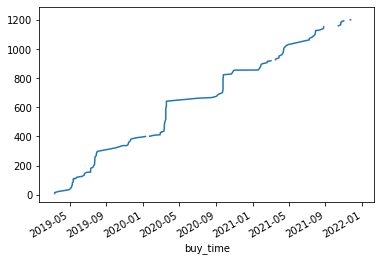

In [12]:
summary_min_grand_all.returns.sum()
summary_min_grand_all.index=summary_min_grand_all.buy_time
summary_min_grand_all.sort_index(inplace=True)
summary_min_grand_all.investment_period=summary_min_grand_all.investment_period.dt.days
summary_min_grand_all['pct_returns_per_day']=summary_min_grand_all.returns/summary_min_grand_all.investment_period

summary_min_grand_all['returns_cumsum']=summary_min_grand_all['returns'].cumsum()
summary_min_grand_all['returns_cumsum'].plot()
#print(summary_min_grand_all.returns.plot)